# Unsupervised learning

Unsupervised learning is a machine learning technique, where you do not need to supervise the model. Instead, you need to allow the model to work on its own to discover information. It mainly deals with the unlabelled data.

#### Why Unsupervised Learning?

* Unsupervised machine learning finds all kind of unknown patterns in data.
* Unsupervised methods help you to find features which can be useful for supervised learning
* It is easier to get unlabeled data than labeled data, which needs manual relabeling.

## Dimensionality Reduction

### PCA (Principal Component Analysis)

Principal Component Analysis is one of the easiest, most intuitive, and most frequently used methods for dimensionality reduction, projecting data onto its orthogonal feature subspace.

#### When should I use PCA?

1. Do you want to reduce the number of variables, but aren’t able to identify variables to completely remove from consideration?
2. Do you want to ensure your variables are independent of one another?
3. Are you comfortable making your independent variables less interpretable? 
4. Try and check on validation (*)

If you answered “yes” to all three questions, then PCA is a good method to use. If you answered “no” to question 3, you should not use PCA.

#### How does PCA work
1. Calculate the covariance matrix X of data points.
2. Calculate eigen vectors and corresponding eigen values.
3. Sort the eigen vectors according to their eigen values in decreasing order.
4. Choose first k eigen vectors and that will be the new k dimensions.
5. Transform the original n dimensional data points into k dimensions.  

You can read more detailed explanation and theory [here](https://habr.com/ru/company/ods/blog/325654/) and [here](https://medium.com/@aptrishu/understanding-principle-component-analysis-e32be0253ef0).

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

data = pd.read_csv("/content/drive/MyDrive/projector_course_data/train_titanic.csv")

X, y = data.drop("Survived", axis = 1), data.Survived

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [38]:
import xgboost as xgb


parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 0,
    "nthread": 10,
    "random_seed": 1,
    "eval_metric": "auc",
    
    # regularization parameters
    "max_leaves": 32,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    
    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}


xgb_train = xgb.DMatrix(X, y.values, feature_names=X.columns)

In [39]:
results = xgb.cv(parameters, xgb_train, num_boost_round=100,
                 folds=skf, verbose_eval=5, early_stopping_rounds=10)

[0]	train-auc:0.878094+0.00453418	test-auc:0.854951+0.0193725
[5]	train-auc:0.903674+0.0022703	test-auc:0.872192+0.00943393
[10]	train-auc:0.908949+0.00125018	test-auc:0.871856+0.00987235
[15]	train-auc:0.919634+0.00180347	test-auc:0.869947+0.0144575


In [40]:
from sklearn.decomposition import PCA

In [41]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [42]:
for i, component in enumerate(pca.components_):
    print(f"{i + 1} component: {100 * pca.explained_variance_ratio_[i]:.2f}% of initial variance")
    print(" + ".join(f"{value:.2f} x {name}"
                     for value, name in zip(component, X.columns)))

1 component: 64.23% of initial variance
0.06 x Pclass + -0.01 x Sex + 0.26 x Age + -0.05 x SibSp + -0.03 x Parch + -0.10 x Fare + 0.00 x Embarked + -0.07 x relatives + 0.03 x not_alone + 0.14 x Deck + -0.05 x Title + 0.94 x Age_Class + -0.03 x Fare_Per_Person
2 component: 15.12% of initial variance
-0.27 x Pclass + 0.02 x Sex + 0.46 x Age + -0.09 x SibSp + -0.03 x Parch + 0.29 x Fare + 0.00 x Embarked + -0.12 x relatives + -0.00 x not_alone + -0.73 x Deck + 0.03 x Title + 0.03 x Age_Class + 0.25 x Fare_Per_Person


In [43]:
xgb_train = xgb.DMatrix(X_reduced, y.values)
results = xgb.cv(parameters, xgb_train, num_boost_round=100,
                 folds=skf, verbose_eval=5, early_stopping_rounds=10)

[0]	train-auc:0.781842+0.00473098	test-auc:0.696202+0.0232507
[5]	train-auc:0.842273+0.00438969	test-auc:0.736722+0.0118745
[10]	train-auc:0.858181+0.00282817	test-auc:0.742914+0.00746699
[15]	train-auc:0.867195+0.00387993	test-auc:0.741851+0.00783717
[20]	train-auc:0.874655+0.00349914	test-auc:0.743113+0.00519642
[25]	train-auc:0.879164+0.00192862	test-auc:0.741444+0.0040519


In [44]:
from matplotlib import pyplot as plt

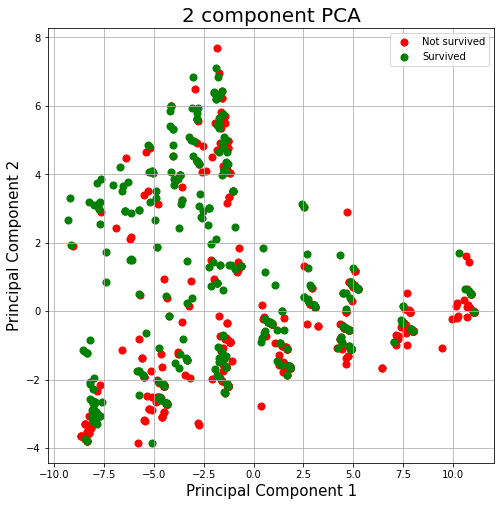

In [45]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ["Not survived", "Survived"]
colors = ['r', 'g']
for target, color in zip([0, 1], colors):
    indices = y == target
    ax.scatter(X_reduced[indices, 0],
               X_reduced[indices, 1],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

## t-SNE

It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked while dissimilar points have an extremely small probability of being picked. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map. Note that while the original algorithm uses the Euclidean distance between objects as the base of its similarity metric, this should be changed as appropriate.

The details for the underlying mathematics can be found in [paper on ArXiv](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).

In [47]:
!pip install cmake==3.18.4
!pip install MulticoreTSNE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.7 MB 563 kB/s 
  Attempting uninstall: cmake
    Found existing installation: cmake 3.22.6
    Uninstalling cmake-3.22.6:
      Successfully uninstalled cmake-3.22.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MulticoreTSNE-0.1.tar.gz (20 kB)
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68517 sha256=5d761a6ae806a949eaeb9ebe77d543904f030993b52f3688fce1c9beddf7d431
  Stored in directory: /root/.cache/pip/wheels/80/47/df/c0d66e9f775f33281c422a1964de86a59c47f93bb8c37643e3
Successfully built MulticoreTSNE


In [48]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=4, )
X_reduced_tsne = tsne.fit_transform(X)

In [49]:
xgb_train = xgb.DMatrix(X_reduced_tsne, y.values)
results = xgb.cv(parameters, xgb_train, num_boost_round=100,
                 folds=skf, verbose_eval=5, early_stopping_rounds=10)

[0]	train-auc:0.736367+0.0223086	test-auc:0.664781+0.0295042
[5]	train-auc:0.839862+0.00872917	test-auc:0.729156+0.0286648
[10]	train-auc:0.855926+0.00843677	test-auc:0.738704+0.0310834
[15]	train-auc:0.862781+0.00932576	test-auc:0.742314+0.024879
[20]	train-auc:0.872132+0.00971549	test-auc:0.744791+0.0277169
[25]	train-auc:0.878827+0.00896424	test-auc:0.746341+0.0242881
[30]	train-auc:0.883704+0.00827118	test-auc:0.748426+0.0266296
[35]	train-auc:0.889578+0.00750419	test-auc:0.746253+0.0284832
[40]	train-auc:0.893561+0.00726992	test-auc:0.748099+0.028245


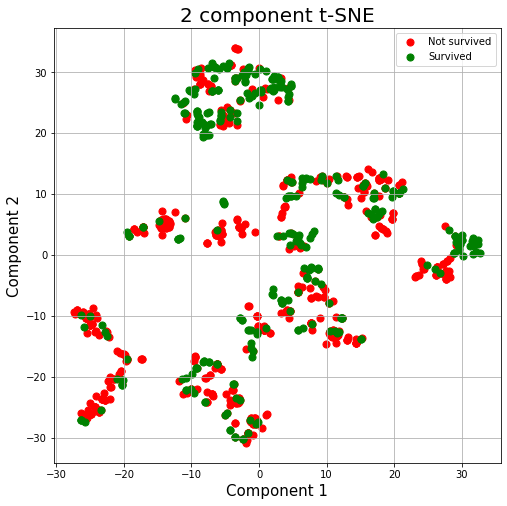

In [50]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
targets = ["Not survived", "Survived"]
colors = ['r', 'g']
for target, color in zip([0, 1], colors):
    indices = y == target
    ax.scatter(X_reduced_tsne[indices, 0],
               X_reduced_tsne[indices, 1],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

## The main purpose of using dimensionality reduction is visualization

In [51]:
from sklearn import datasets

digits = datasets.load_digits()

tsne = TSNE()
embeddings_tsne = tsne.fit_transform(digits.data)

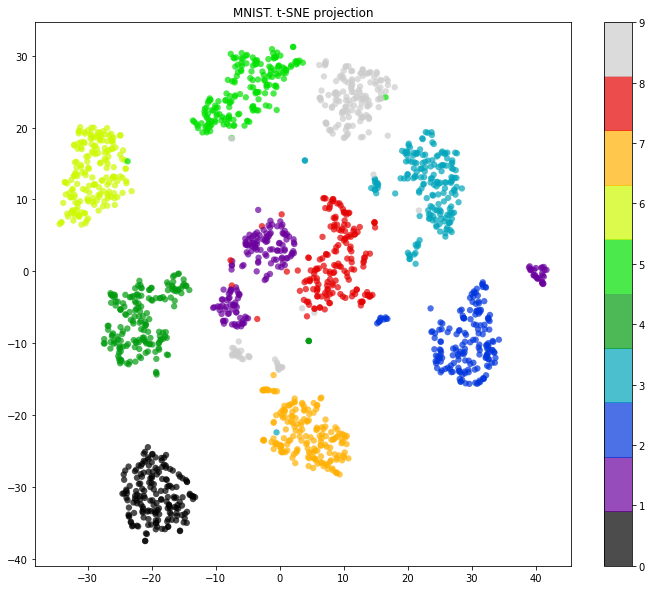

In [52]:
plt.figure(figsize=(12,10))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=digits.target, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

## UMAP

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data:

1. The data is uniformly distributed on a Riemannian manifold;
2. The Riemannian metric is locally constant (or can be approximated as such);
3. The manifold is locally connected.

From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

The details for the underlying mathematics can be found in [paper on ArXiv](https://arxiv.org/abs/1802.03426).

Read about [UMAP benefits](https://github.com/lmcinnes/umap#benefits-of-umap).

In [53]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import umap
embedding_umap = umap.UMAP(n_neighbors=5).fit_transform(digits.data)


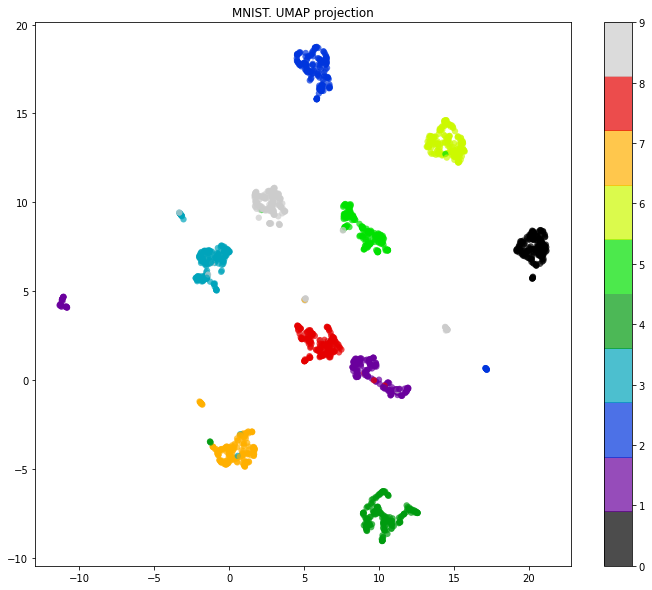

In [55]:
plt.figure(figsize=(12,10))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=digits.target, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. UMAP projection');

Dimensionality reduction rarely works well on the real data. 

T-SNE and UMAP are usually better than other dimensionality reduction algorithms.

Main use cases:
* beautiful visualizations – visualize different embeddings (texts, images, etc)
* if you have many features (works very poorly on small dimensions)
* estimate data complexity
* reduce feature space (aggregate many bad features)
* doesn't work on categorical data, on continuous numeric data – you have a chance
* course lecture :)

## Clustering

Clustering is the task of dividing the population or data points into a number of groups such that data points in the same groups are more similar to other data points in the same group than those in other groups. In simple words, the aim is to segregate groups with similar traits and assign them into clusters.

#### Types of Clustering
Broadly speaking, clustering can be divided into two subgroups :

* **Hard Clustering**: In hard clustering, each data point either belongs to a cluster completely or not. For example, in the above example each customer is put into one group out of the 10 groups.
* **Soft Clustering**: In soft clustering, instead of putting each data point into a separate cluster, a probability or likelihood of that data point to be in those clusters is assigned. For example, from the above scenario each costumer is assigned a probability to be in either of 10 clusters of the retail store.

![image.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)

## K-means

1. To begin, we first select a number of classes/groups to use and randomly initialize their respective center points. To figure out the number of classes to use, it’s good to take a quick look at the data and try to identify any distinct groupings. The center points are vectors of the same length as each data point vector and are the “X’s” in the graphic above.
2. Each data point is classified by computing the distance between that point and each group center, and then classifying the point to be in the group whose center is closest to it.
3. Based on these classified points, we recompute the group center by taking the mean of all the vectors in the group.
4. Repeat these steps for a set number of iterations or until the group centers don’t change much between iterations. You can also opt to randomly initialize the group centers a few times, and then select the run that looks like it provided the best results.

![image](https://miro.medium.com/max/960/1*KrcZK0xYgTa4qFrVr0fO2w.gif)

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. **The Elbow Method** is one of the most popular methods to determine this optimal value of k.

1. Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
2. Inertia: It is the sum of squared distances of samples to their closest cluster center.

In [56]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

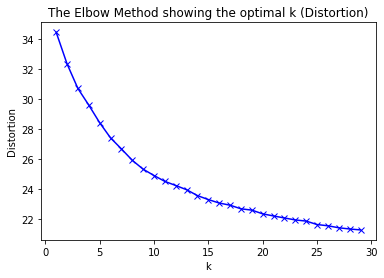

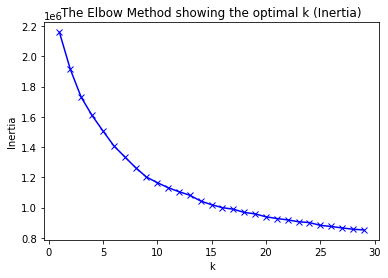

In [58]:
distortions = []
inertias = []
ks = range(1,30)
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(digits.data)
    distortions.append(sum(np.min(cdist(digits.data, model.cluster_centers_, 'euclidean'), axis=1)) / digits.data.shape[0])
    inertias.append(model.inertia_)

# Plot the elbow
plt.plot(ks, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k (Distortion)')
plt.show();

# Plot the elbow
plt.plot(ks, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k (Inertia)')
plt.show()

In [60]:
model_kmeans = KMeans(n_clusters=10)
model_kmeans.fit(digits.data)
data_clusters = model_kmeans.predict(digits.data)

In [61]:
data = pd.DataFrame({"clusters": data_clusters, "labels": digits.target})

In [62]:
data.loc[data["labels"] == 0, "clusters"].value_counts()

5    177
0      1
Name: clusters, dtype: int64

In [63]:
data.loc[data["clusters"] == 1, "labels"].value_counts()

3    155
2     13
9      6
8      2
5      1
1      1
Name: labels, dtype: int64

In [64]:
data.loc[(data["clusters"] == 1) & (data["labels"] == 6)]

,clusters,labels


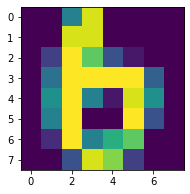

In [65]:
plt.figure(figsize=(3, 3))
plt.imshow(digits.data[792,:].reshape([8,8]));

## Affinity Propagation

**Affinity propagation (AP)** is a centroid based clustering algorithm similar to k Means or K medoids, which does not require the estimation of the number of clusters before running the algorithm. Affinity propagation finds objects that are representative of clusters.

Theoretical explanation you can read [here](https://towardsdatascience.com/math-and-intuition-behind-affinity-propagation-4ec5feae5b23).

In [66]:
from sklearn.cluster import AffinityPropagation

In [67]:
model_aff = AffinityPropagation()
model_aff.fit(digits.data)

AffinityPropagation()

In [68]:
max(model_aff.labels_)

102

## Hierarchical clustering

Hierarchical clustering is one of the popular and easy to understand clustering technique. This clustering technique is divided into two types:
1. Agglomerative
2. Divisive

### Agglomerative Hierarchical clustering
In this technique, initially each data point is considered as an individual cluster. At each iteration, the similar clusters merge with other clusters until one cluster or K clusters are formed.

The basic algorithm of Agglomerative is straight forward:
1. Compute the proximity matrix
2. Let each data point be a cluster
3. Repeat: Merge the two closest clusters and update the proximity matrix
4. Until only a single cluster remains

Key operation is the computation of the proximity of two clusters.

The Hierarchical clustering Technique can be visualized using a Dendrogram. A Dendrogram is a tree-like diagram that records the sequences of merges or splits.


### Divisive Hierarchical clustering Technique
In simple words, we can say that the Divisive Hierarchical clustering is exactly the opposite of the Agglomerative Hierarchical clustering. In Divisive Hierarchical clustering, we consider all the data points as a single cluster and in each iteration, we separate the data points from the cluster which are not similar. Each data point which is separated is considered as an individual cluster. In the end, we’ll be left with n clusters.
As we’re dividing the single clusters into n clusters, it is named as Divisive Hierarchical clustering.

In [69]:
from sklearn.cluster import AgglomerativeClustering

In [70]:
model_agglom = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model_agglom.fit(digits.data)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [71]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

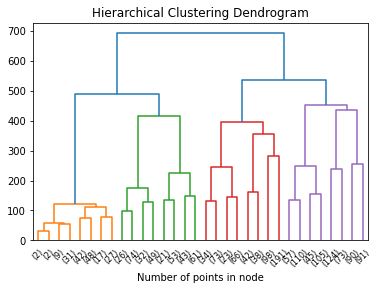

In [72]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model_agglom, truncate_mode='level', p=4)
plt.xlabel("Number of points in node")
plt.show();

## Clustering metrics

### Adjusted Rand Index

Here, we assume that the true labels of objects are known. This metric does not depend on the labels’ values but on the data cluster split. 

Let N be the number of observations in a sample. Let $a$ to be the number of observation pairs with the same labels and located in the same cluster, and let $b$ to be the number of observations with different labels and located in different clusters. 

The Rand Index can be calculated using the following formula: 
$$RI = \frac{2(a + b)}{n(n — 1)}$$ 
In other words, it evaluates a share of observations for which these splits (initial and clustering result) are consistent. The Rand Index (RI) evaluates the similarity of the two splits of the same sample. In order for this index to be close to zero for any clustering outcomes with any n and number of clusters, it is essential to scale it, hence the Adjusted Rand Index: $$ARI = \frac{RI — E(RI)}{max(RI) — E(RI)}$$
This metric is symmetric and does not depend in the label permutation. Therefore, this index is a measure of distances between different sample splits. ARI takes on values in the [-1, 1] range. Negative values indicate the independence of splits, and positive values indicate that these splits are consistent (they match ARI = 1).

### Adjusted Mutual Information (AMI)

This metric is similar to ARI. It is also symmetric and does not depend on the labels’ values and permutation. It is defined by the entropy function and interprets a sample split as a discrete distribution (likelihood of assigning to a cluster is equal to the percent of objects in it). The MI index is defined as the mutual information for two distributions, corresponding to the sample split into clusters. Intuitively, the mutual information measures the share of information common for both clustering splits i.e. how information about one of them decreases the uncertainty of the other one.
Similarly to the ARI, the AMI is defined. This allows us to get rid of the MI index’s increase with the number of clusters. The AMI lies in the [0, 1] range. Values close to zero mean the splits are independent, and those close to 1 mean they are similar (with complete match at AMI = 1).


### Silhouette
Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified.

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.

$$ s = \frac{b - a}{max(a, b)} $$,
where a – the mean distance between an object and all other data points in the same cluster; b – the smallest mean distance of an object to all points in any other cluster.

### Homework
1. Do clustering on the digits dataset from sklearn using at least three different approaches
2. Evaluate the quality of clustering using three metrics from the lecture
3. Apply dimensionality reduction, then do clustering and calculate metrics.
4. Make a comparison table of different clustering approaches with and without dimensionality reduction.

In this task, we want to use 10 clusters, as we have 10 digits.